## Heterogeneous Treatment Effects

In the first few notebook examples, we were mostly concerned with the estimation of **average** treatment effects, in order to determine whether treatment is overall effective or not. That is totally fine from a perspective of understanding the world and how it operates under the hood. However, intuitively we know that some treated individuals won't have the same response to treatment. In fact, some individuals - regardless of being treated or not - will have a stronger response to treatment.

Hence, it makes sense for us, especially in business contexts, to find the individuals that will respond better to a given treatment, in order to leverage profitability, for instance. Also, when we determine ATE, we are talking about a population of millions of customers. Therefore, it can be unfeasible, from a budget limititation's standpoint, to treate every single customer... What we can do is find the top customers and treat them preferrably.

But how can we do that?

The anwers lies in **Machine Learning**!! We have been used to a passive approach to ML, where we simply predict most profitable customers and we stop there. However, we can leverage predictive models in a more **active approach**, in order to predict which customers should receive the treatment and then treat them in the specific business context.

In a nutshell, the question we want to answer has a slightly different form now: **Who do we treat?**

### Libraries

In [1]:
import numpy as np
import pandas as pd
from matplotlib import style
import matplotlib.pyplot as plt
import seaborn as sns
style.use("fivethirtyeight")

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from lightgbm import LGBMRegressor

### Data

For this dataset, `smoker` is our treatment variable, while `psyc_distress` is our outcome variable. The main idea is that we will match smokers and non-smokers according to a set of covariates, including `sex` (0: Female; 1: Male), `indigeneity` (0: Non-indigenous; 1: indigenous), `high_school` (0: not finished high school; 1: finished high school), `partnered` (0: not partnered; 1: partnered), `remoteness` (0: major cities; 1: inner regional; 2: outer regional), `language` (0: non-English speaking; 1: English speaking), `age` and `risky_alcohol` (alcohol use - 0: not risky; 1: risky).

In [2]:
df = pd.read_csv("../data/smoking_psyc_distress.csv",)
df.head()

,sex,indigeneity,high_school,partnered,remoteness,language,smoker,risky_alcohol,psyc_distress,age
0,0,0,1,1,0,1,0,0,13,63
1,0,0,1,1,0,1,0,1,11,48
2,0,0,0,0,0,1,0,1,11,54
3,1,0,1,1,0,1,0,1,12,50
4,0,0,0,1,1,1,0,1,10,67


In [3]:
df.describe()

,sex,indigeneity,high_school,partnered,remoteness,language,smoker,risky_alcohol,psyc_distress,age
count,8000.000000,8000.000000,8000.00000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.00000,8000.000000
mean,0.448375,0.021750,0.61150,0.663500,0.474375,0.918500,0.121750,0.553500,15.07025,53.517375
std,0.497359,0.145875,0.48744,0.472542,0.728292,0.273619,0.327017,0.497161,5.73408,14.193762
min,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,10.00000,30.000000
25%,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,11.00000,41.000000
50%,0.000000,0.000000,1.00000,1.000000,0.000000,1.000000,0.000000,1.000000,13.00000,54.000000
75%,1.000000,0.000000,1.00000,1.000000,1.000000,1.000000,0.000000,1.000000,17.00000,66.000000
max,1.000000,1.000000,1.00000,1.000000,2.000000,1.000000,1.000000,1.000000,50.00000,79.000000


Some basic definitions:

In [4]:
Y = "psyc_distress"
T = "smoker"
X = [c for c in df.columns if not c in [Y, T]]

> Now we are going to take a look at several approaches for computing CATE

Before we proceed, let's split the dataset into a training and a test sets.

In [5]:
df_train, df_test = train_test_split(df, test_size=0.30, random_state=99)

### 1. S-Learner

This is known as the *Go-Horse Learner*, as it is indeed the simplest model we can possible come up with. The idea is to fit a model $M_{s}(X, T)$ that uses both covariates and treatment as predictors.

Then, at inference time, we get predictions while setting $T=1$ for the whole base and subtract from the predictions when setting $T=0$ for the whole base. Mathematically:

$\hat{\tau}(x)_{i} = M_{s}(X_{i}, T=1) - M_{s}(X_{i}, T=0)$

In [6]:
np.random.seed(99)

class SLearnerModel(object):

    def __init__(self, Y, T, X):
        self._Y = Y
        self._T = T
        self._X = X
        self._model = LGBMRegressor(max_depth=3, min_child_samples=30, random_state=99)

    def fit(self, df: pd.DataFrame):
        self._model.fit(df[self._X + [self._T]], df[self._Y])

    def predict(self, df: pd.DataFrame):
        return (
            self._model.predict(df[self._X].assign(**{self._T: 1})) -
            self._model.predict(df[self._X].assign(**{self._T: 0}))
        )

model = SLearnerModel(Y, T, X)
model.fit(df_train)

df_s_train = df_train.assign(
    cate=(
        model.predict(df_train)
    )
)
df_s_test = df_test.assign(
    cate=(
        model.predict(df_test)
    )
)

In [7]:
df_s_test.head()

,sex,indigeneity,high_school,partnered,remoteness,language,smoker,risky_alcohol,psyc_distress,age,cate
4607,1,0,1,1,0,1,0,0,10,71,0.657327
744,0,0,1,1,0,1,0,1,12,30,2.205003
2386,0,0,0,1,1,1,0,1,10,73,1.051395
907,0,0,1,1,1,1,0,1,14,37,1.859353
3799,1,0,1,0,0,1,0,1,13,43,3.691587


Ok, we've got our predictions for CATE... The question now is: **How do we evaluate whether or not the performance is satisfactory?**

In a nutshell, what we are attempting to predict is the **elasticity** - how each individual's outcome vary when changing $T=0$ to $T=1$. Mathematically, $\frac{\delta y}{\delta T}$ is what we would like to obtain, and of course it is **unobservable**.

The main idea behind heterogeneous effects is that some individuals are more sensitive to treatment than others. Then, it makes sense to order them according to their sensitivity.

Then, we can go from the most sensitive units to the least one. Even better, we can think of a **CUMULATIVE ELASTICITY CURVE**, where at the end we will just converge to the ATE for the whole dataset.

Mathematically, we can define the cumulative elasticity as:

$(\frac{\delta y}{\delta T})_{k} = \frac{\sum_{i=1}^{k}(t_{i}-\overline{t})(y_{i} - \overline{y})}{\sum_{i=1}^{k}(t_{i}-\overline{t})^2}$

which is simply the definition of the coefficient for the treatment variable, for a simple linear regression.

Interpreting this curbe is somehow burdensome. The X axis of the curve represents how many samples are we treating. The Y axis is the elasticity we should expect at that many samples. So, if a curve has value 3 at 10%, it means that the elasticity of the top 10% units is 3. **Ideally, we strive for the highest elasticity for the largest possible sample**. An ideal curve then would start high up on the Y axis and descend very slowly to the average elasticity.

Nevertheless, we can make a tweak to this curve and improve its interpretability... Let's just multiply the sample size until that point the current cumulative elasticity. This is the so-called **CUMULATIVE GAIN CURVE**, which is conceptually very similar to a ROC when evaluating ML models - the random model will be a diagonal straight line. **The better the model at ordering elasticity, the more the curve will diverge from the random line in the points between zero and one**.

Once again, mathematically

$\hat{F(t)_{k}} = \frac{\sum_{i=1}^{k}(t_{i}-\overline{t})(y_{i} - \overline{y})}{\sum_{i=1}^{k}(t_{i}-\overline{t})^2} \frac{k}{N}$

In [8]:
class CumulativeGainEvaluator(object):

    _CUMULATIVE_ELASTICITY = "cumulative_elasticity"
    _CUMULATIVE_GAIN = "cumulative_gain"
    _CATE = "cate"
    
    def __init__(
        self,
        train: pd.DataFrame,
        test: pd.DataFrame,
        model: BaseEstimator,
        outcome: str,
        treatment: str,
        covariates: list[str],
        model_name: str,
    ) -> None:
        self._train = train.copy()
        self._test = test.copy()
        self._model = model
        self._outcome = outcome
        self._treatment = treatment
        self._covariates = covariates
        self._model_name = model_name

        self._fitted = False

    def _compute_cate(self, df: pd.DataFrame) -> pd.DataFrame:
        return df.assign(**{
            self._CATE: self._model.predict(df)
        })
    
    def _sort_by_cate(self, df: pd.DataFrame) -> pd.DataFrame:
        return df.sort_values(by=self._CATE, ascending=False)
    
    def _compute_cumulative_elasticity(self, df: pd.DataFrame) -> pd.DataFrame:
        elasticity = [np.nan]
        for idx in range(2, len(df) + 1):
            cur_df = df.iloc[:idx]
            current_avg_treatment = cur_df[self._treatment].mean()
            current_avg_outcome = cur_df[self._outcome].mean()
            numerator = np.sum(
                (cur_df[self._treatment] - current_avg_treatment) *
                (cur_df[self._outcome] - current_avg_outcome)
            )
            denominator = np.sum(
                (cur_df[self._treatment] - current_avg_treatment) ** 2
            )
            elasticity.append(numerator / denominator)
        return df.assign(**{
            self._CUMULATIVE_ELASTICITY: np.array(elasticity)
        })
    
    def _compute_cumulative_gain(self, df: pd.DataFrame) -> pd.DataFrame:
        df = self._compute_cate(df)
        df = self._sort_by_cate(df)

        df = df.assign(sample_frac=np.arange(1, len(df)+1) / len(df))
        df = self._compute_cumulative_elasticity(df)
        
        return df.assign(**{
            self._CUMULATIVE_GAIN: lambda x: x[self._CUMULATIVE_ELASTICITY] * x["sample_frac"]
        })
    
    def fit(self) -> None:
        self._train = self._compute_cumulative_gain(self._train)
        self._test = self._compute_cumulative_gain(self._test)
        self._fitted = True

    def eval(self) -> None:
        _, ax = plt.subplots(1, 1, figsize=(10, 6))

        ax.plot(self._train["sample_frac"], self._train[self._CUMULATIVE_GAIN], label="train")
        ax.plot(self._test["sample_frac"], self._test[self._CUMULATIVE_GAIN], label="test")
        ax.plot(self._test.loc[~self._test[self._CUMULATIVE_GAIN].isnull(), "sample_frac"].values[[0, -1]], self._test.loc[~self._test[self._CUMULATIVE_GAIN].isnull(), self._CUMULATIVE_GAIN].values[[0, -1]],
                 linestyle="--", color="grey", linewidth=2, label="random")
        ax.set_title(f"Cumulative Gain Curve [{self._model_name}]")
        ax.set_xlabel("% of Sample")
        ax.set_ylabel("Cumulative Gain")
        plt.legend()
        plt.show()

In [9]:
cumulative_gain_eval = CumulativeGainEvaluator(
    train=df_train,
    test=df_test,
    model=model,
    outcome=Y,
    treatment=T,
    covariates=X,
    model_name="S-Learner"
)

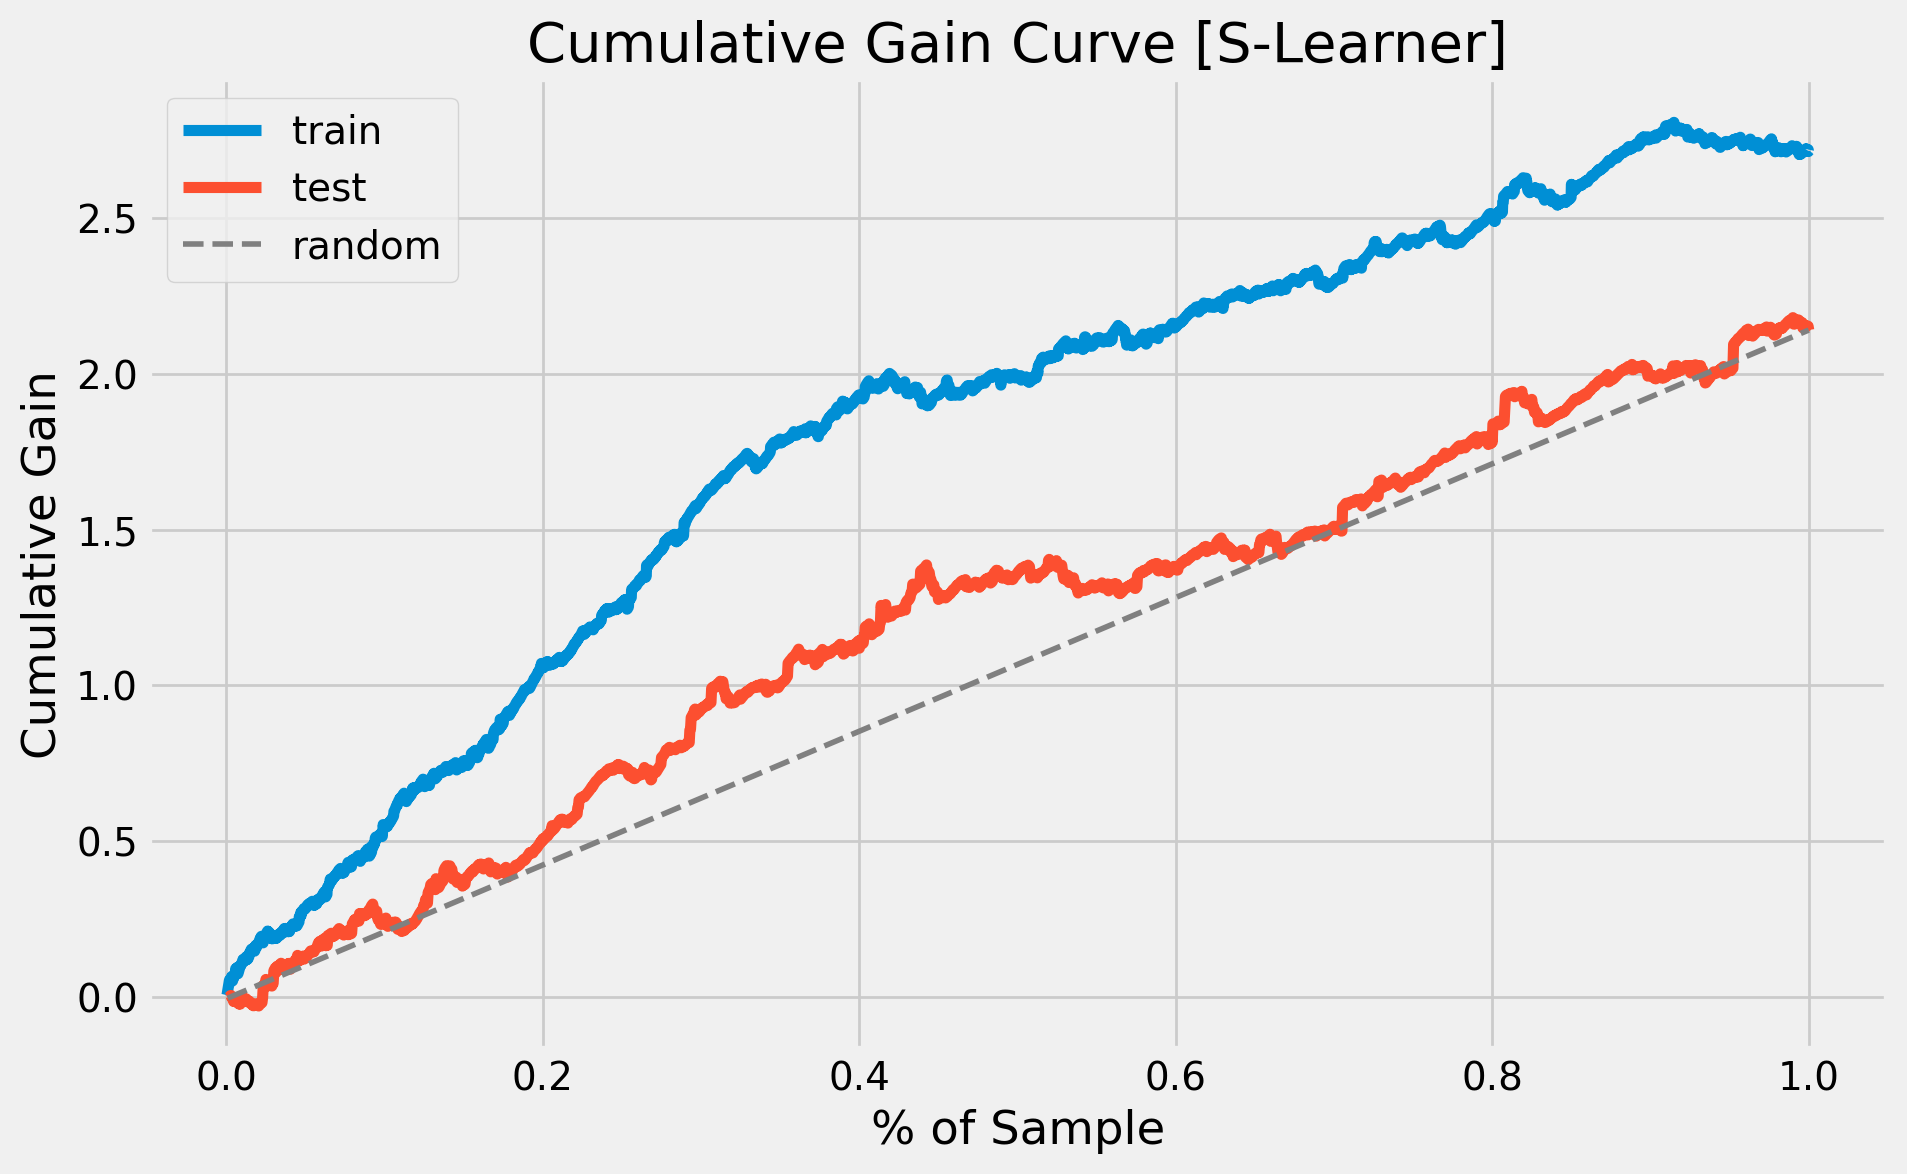

In [10]:
cumulative_gain_eval.fit()
cumulative_gain_eval.eval()

Or it could be as simple as...

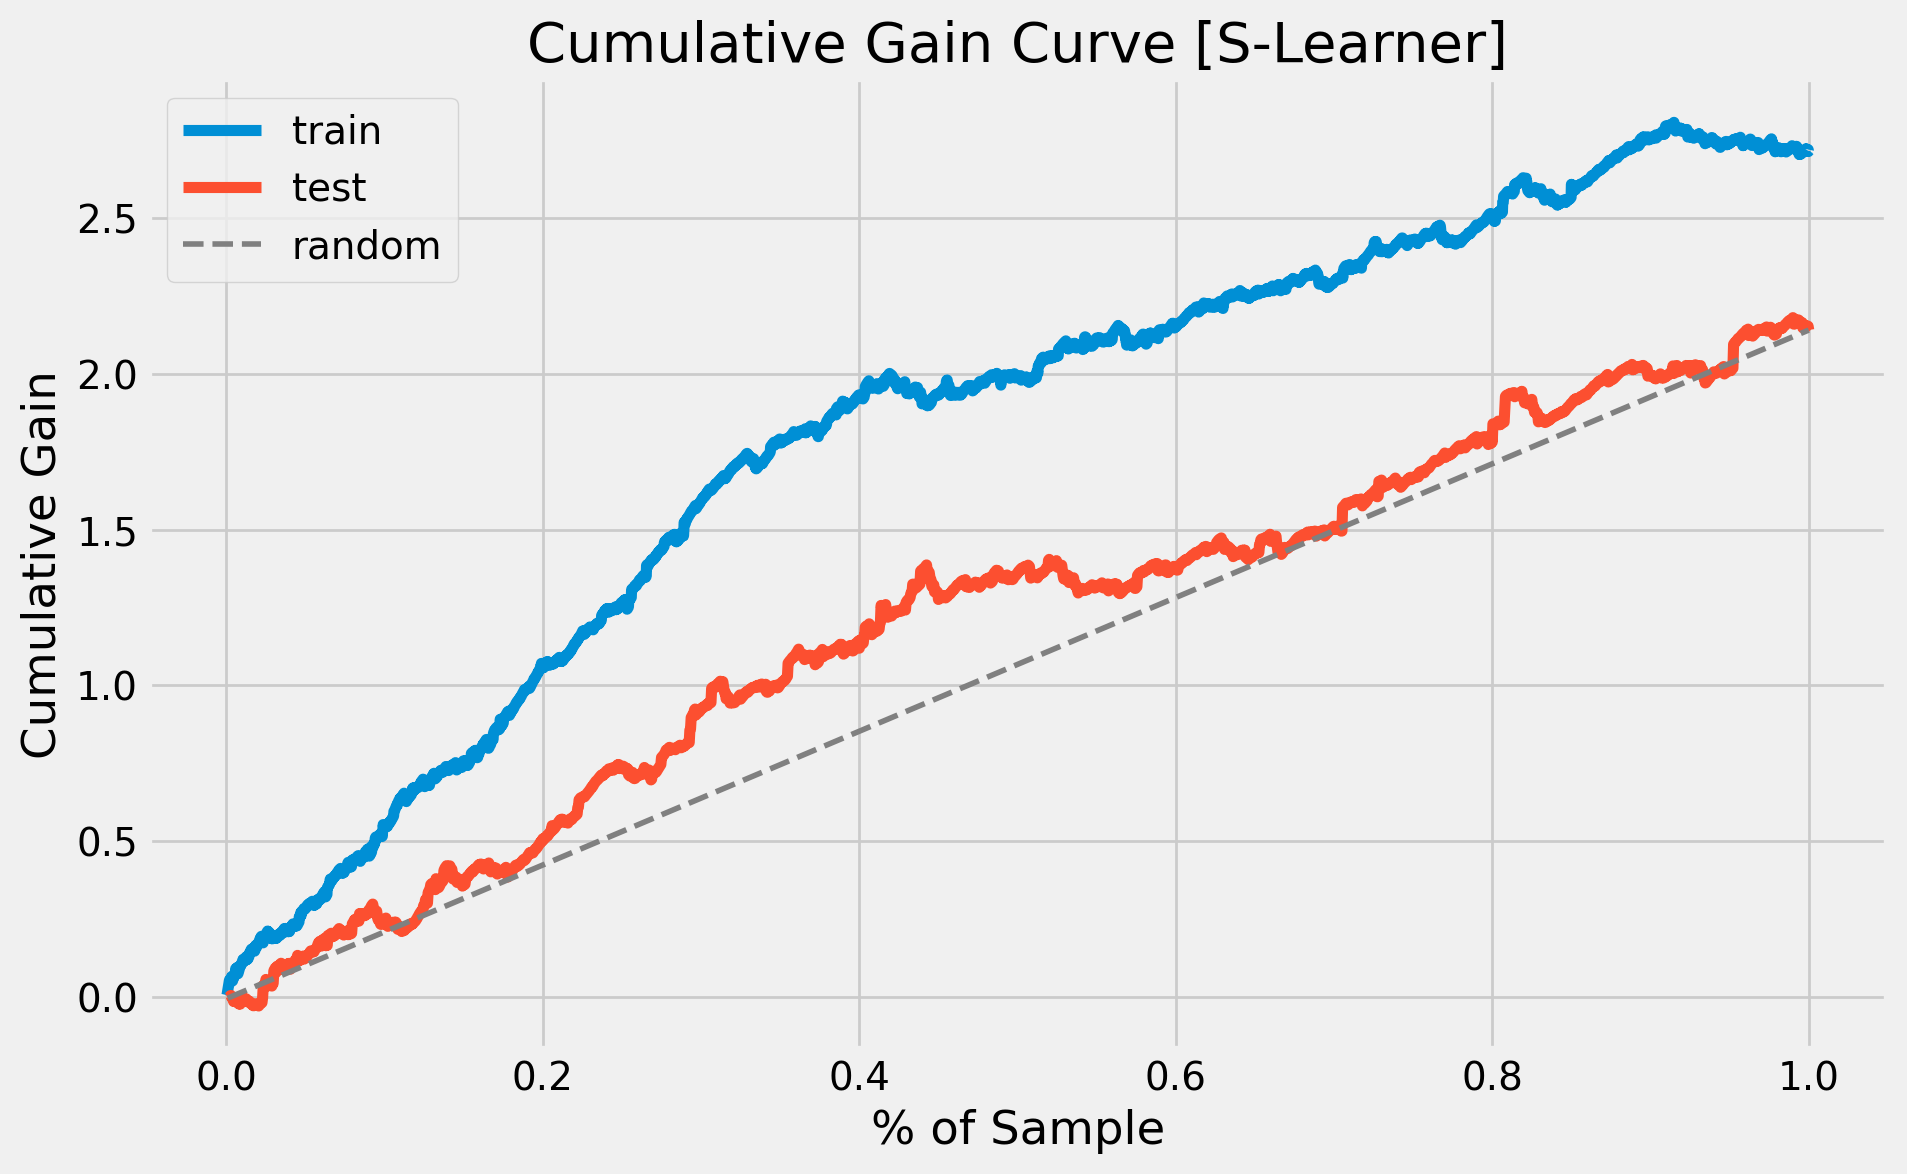

In [11]:
from causal_inference.ml import SLearner

model = SLearner(
    data=df,
    outcome=Y,
    treatment=T,
    covariates=X,
)
model.fit()
model.eval()

### 2. T-Learner

The S-learner is a good first bet for any causal problem, mostly due to its simplicity. However, it has some shortcomings:

* The treatment effect is biased towards zero;

* It might the case that the treatment is not a significant variable within the model, hence being discarded.

The T-Learner tweaks the current approach a little bit by **forcing the first split to be on the treatment variable (binary)**. In short, we just fit two different models: one for $T=1$ and the other for $T=0$. Then, we simply apply both models to the covariates and subtract them.

* $\mu_{0}(x) = \mathbb{E}[Y|T=0,X]$  
* $\mu_{1}(x) = \mathbb{E}[Y|T=1,X]$

Therefore:

$\hat{\tau}(x)_{i} = M_{1}(X_{i}) - M_{0}(X_{i})$

In [12]:
np.random.seed(99)

class TLearnerModel(object):

    def __init__(self, Y, T, X):
        self._Y = Y
        self._T = T
        self._X = X
        self._model_T1 = LGBMRegressor(max_depth=3, min_child_samples=30, random_state=99)
        self._model_T0 = LGBMRegressor(max_depth=3, min_child_samples=30, random_state=99)

    def fit(self, df: pd.DataFrame):
        self._model_T1.fit(df.query(f"{self._T} == 1")[self._X], df.query(f"{self._T} == 1")[self._Y])
        self._model_T0.fit(df.query(f"{self._T} == 0")[self._X], df.query(f"{self._T} == 0")[self._Y])

    def predict(self, df: pd.DataFrame):
        return (
            self._model_T1.predict(df[self._X]) -
            self._model_T0.predict(df[self._X])
        )

model = TLearnerModel(Y, T, X)
model.fit(df_train)

df_s_train = df_train.assign(
    cate=(
        model.predict(df_train)
    )
)
df_s_test = df_test.assign(
    cate=(
        model.predict(df_test)
    )
)

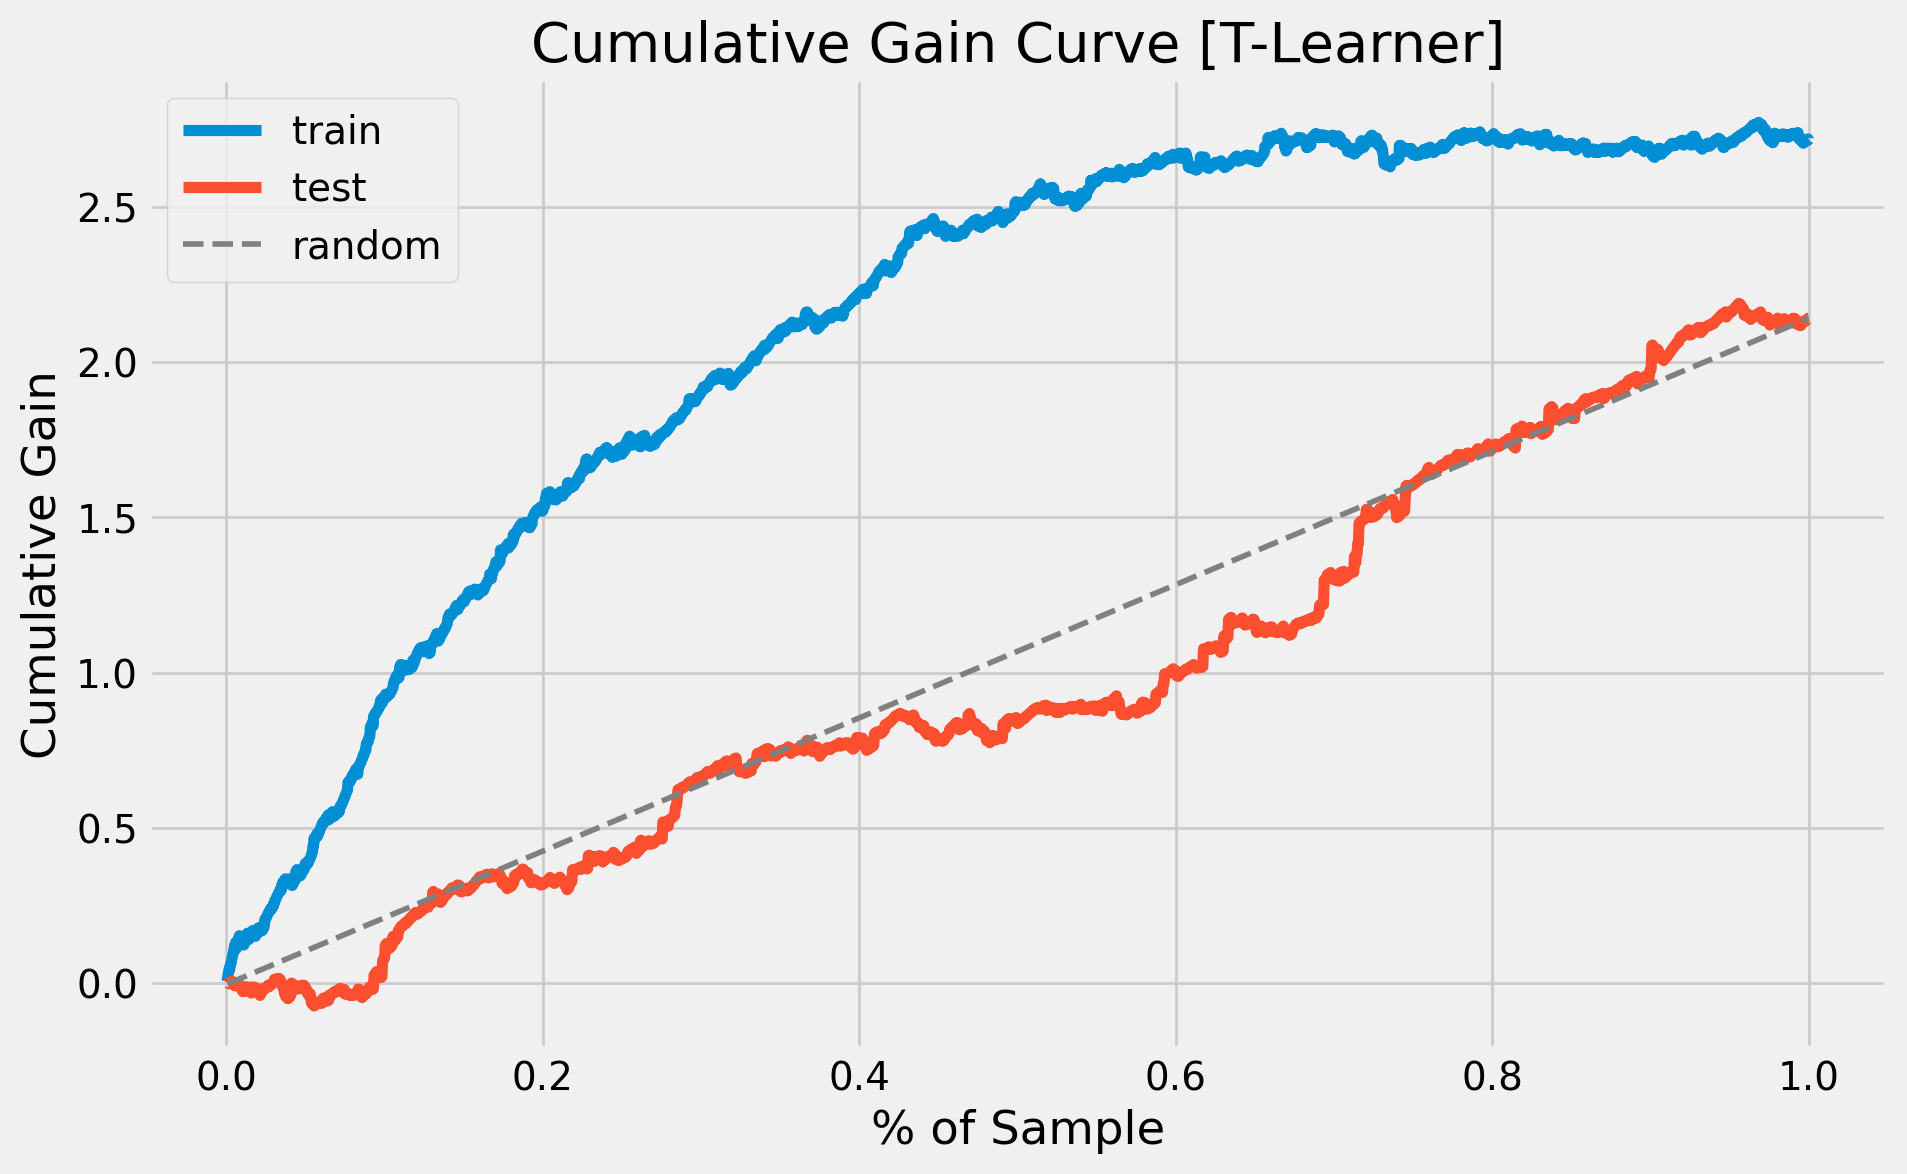

In [13]:
cumulative_gain_eval = CumulativeGainEvaluator(
    train=df_train,
    test=df_test,
    model=model,
    outcome=Y,
    treatment=T,
    covariates=X,
    model_name="T-Learner"
)
cumulative_gain_eval.fit()
cumulative_gain_eval.eval()

We can see that the T-Learner performs much worse than S-Learner, as it roughly follows what is expected from a random model.

Once again, we can rely on our own package for this task:

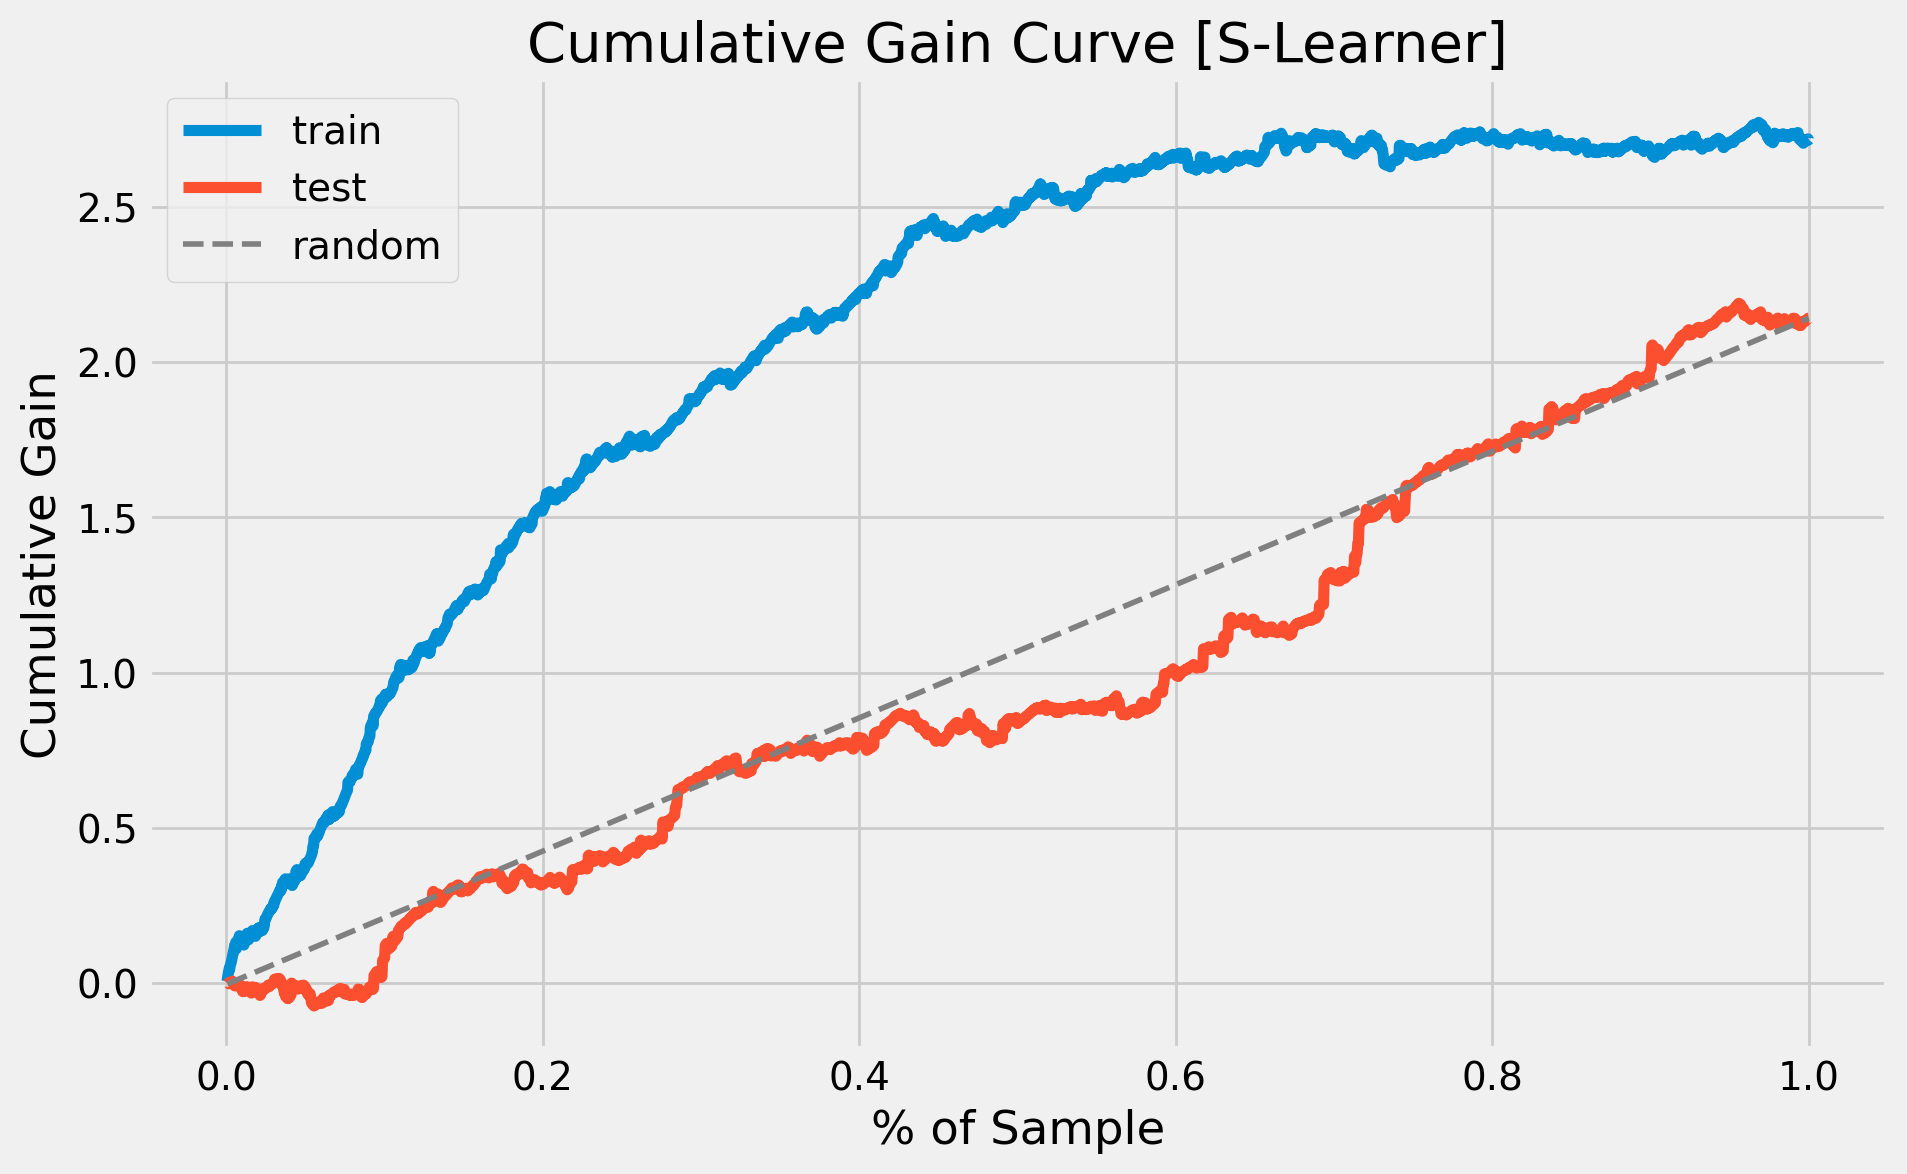

In [14]:
from causal_inference.ml import TLearner

model = TLearner(
    data=df,
    outcome=Y,
    treatment=T,
    covariates=X,
)
model.fit()
model.eval()

### 3. X-Learner

Things get a little bit more complex to explain when we get to the X-Learner. Let's take a look at the steps we need to follow:

**(1) We split the samples into treated ($T=1$) and control ($T=0$), and fit a model for each - Just like the T-Learner**

* $\hat{M_{0}}(x) = \mathbb{E}[Y|T=0,X]$  
* $\hat{M_{1}}(x) = \mathbb{E}[Y|T=1,X]$

**(2) We compute contefactuals and associated effects by imputing the treatment variables in each sample**

* $\hat{\tau}(X,T=0) = \hat{M_{1}}(X, T=0) - Y_{X=0}$  
* $\hat{\tau}(X,T=1) = Y_{X=1} - \hat{M_{0}}(X, T=1)$  

**(3) We fit two more models to predict these estimated effects**

* $\hat{M_{\tau_{0}}}(x)= \mathbb{E}[\hat{\tau}(X)|T=0]$  
* $\hat{M_{\tau_{1}}}(x)= \mathbb{E}[\hat{\tau}(X)|T=1]$  

**(4) Now we combine both models in a way that gives more weight to unbiased $\hat{M_{\tau_{1}}}(x)$**

$\hat{\tau}(x)= \hat{M_{\tau_{0}}}(x) \hat{e}(x) + \hat{M_{\tau_{1}}}(x) (1-\hat{e}(x))$  ,


where $\hat{e}(x)$ is the **propensity score**.


In general the X-learner performs better when a treatment group is much larger than the other.

In [15]:
np.random.seed(99)

class XLearnerModel(object):

    def __init__(self, Y, T, X_cat, X_num):
        self._Y = Y
        self._T = T
        self._X_cat = X_cat if isinstance(X_cat, list) else [X_cat]
        self._X_num = X_num if isinstance(X_num, list) else [X_num]
        self._X = self._X_cat + self._X_num
        self._model_T1 = LGBMRegressor(max_depth=2, min_child_samples=30, random_state=99)
        self._model_T0 = LGBMRegressor(max_depth=2, min_child_samples=30, random_state=99)
        self._model_tau1 = LGBMRegressor(max_depth=2, min_child_samples=30, random_state=99)
        self._model_tau0 = LGBMRegressor(max_depth=2, min_child_samples=30, random_state=99)
        self._lr = Pipeline(steps=[
            ("preprocessing", ColumnTransformer(transformers=[
                ("scale", StandardScaler(), self._X_num),
                ("ohe", OneHotEncoder(drop="first", sparse_output=False), self._X_cat), 
            ], remainder="passthrough")),
            ("lr", LogisticRegression(random_state=99))
        ])

    def fit(self, df: pd.DataFrame):
        # 1st Stage
        self._model_T1.fit(df.query(f"{self._T} == 1")[self._X], df.query(f"{self._T} == 1")[self._Y])
        self._model_T0.fit(df.query(f"{self._T} == 0")[self._X], df.query(f"{self._T} == 0")[self._Y])

        # 2nd stage
        tau = np.where(
            df[self._T] == 0,
            self._model_T1.predict(df[self._X]) - df[self._Y],
            df[self._Y] - self._model_T0.predict(df[self._X]),
        )

        # 3rd stage
        self._model_tau1.fit(df.query(f"{self._T} == 1")[self._X], tau[df[self._T] == 1])
        self._model_tau0.fit(df.query(f"{self._T} == 0")[self._X], tau[df[self._T] == 0])

        # PS Model
        self._lr.fit(df[self._X], df[self._T])

    def predict(self, df: pd.DataFrame):
        return (
            self._lr.predict_proba(df[self._X])[:, 1] * self._model_tau0.predict(df[self._X]) +
            (1 - self._lr.predict_proba(df[self._X])[:, 1]) * self._model_tau1.predict(df[self._X])
        )

model = XLearnerModel(Y, T, X_num="age", X_cat=[col for col in X if col!="age"])
model.fit(df_train)

df_s_train = df_train.assign(
    cate=(
        model.predict(df_train)
    )
)
df_s_test = df_test.assign(
    cate=(
        model.predict(df_test)
    )
)

/var/folders/m9/jt5_hds11clcrcs2hvpxzhpm0000gn/T/ipykernel_37738/3669873955.py:48: RuntimeWarning: invalid value encountered in scalar divide
  elasticity.append(numerator / denominator)


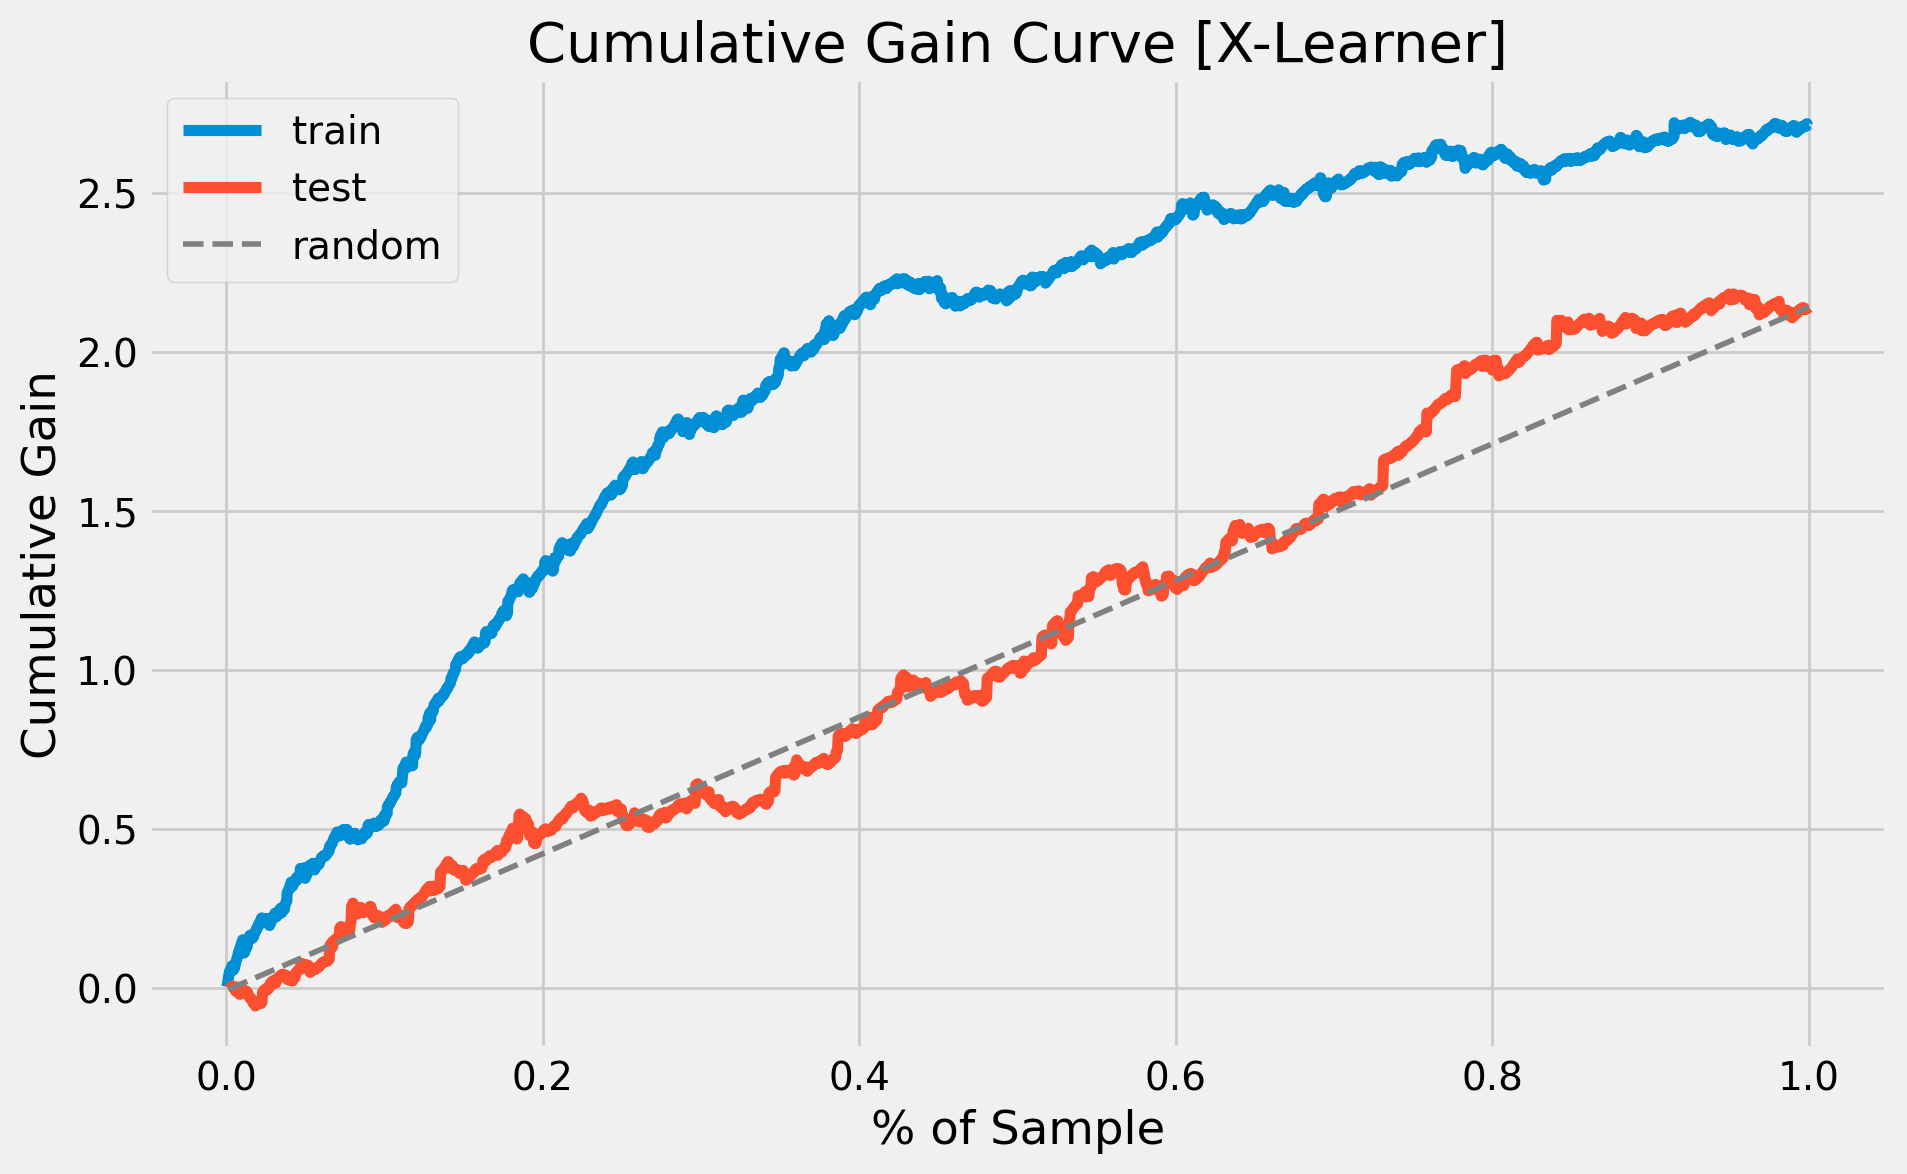

In [16]:
cumulative_gain_eval = CumulativeGainEvaluator(
    train=df_train,
    test=df_test,
    model=model,
    outcome=Y,
    treatment=T,
    covariates=X,
    model_name="X-Learner"
)
cumulative_gain_eval.fit()
cumulative_gain_eval.eval()

Once again, we can rely on our own package for this task:

/Users/gfluz94/.causal-inference/lib/python3.11/site-packages/causal_inference-0.0.1-py3.11.egg/causal_inference/ml/evaluation.py:64: RuntimeWarning: invalid value encountered in scalar divide


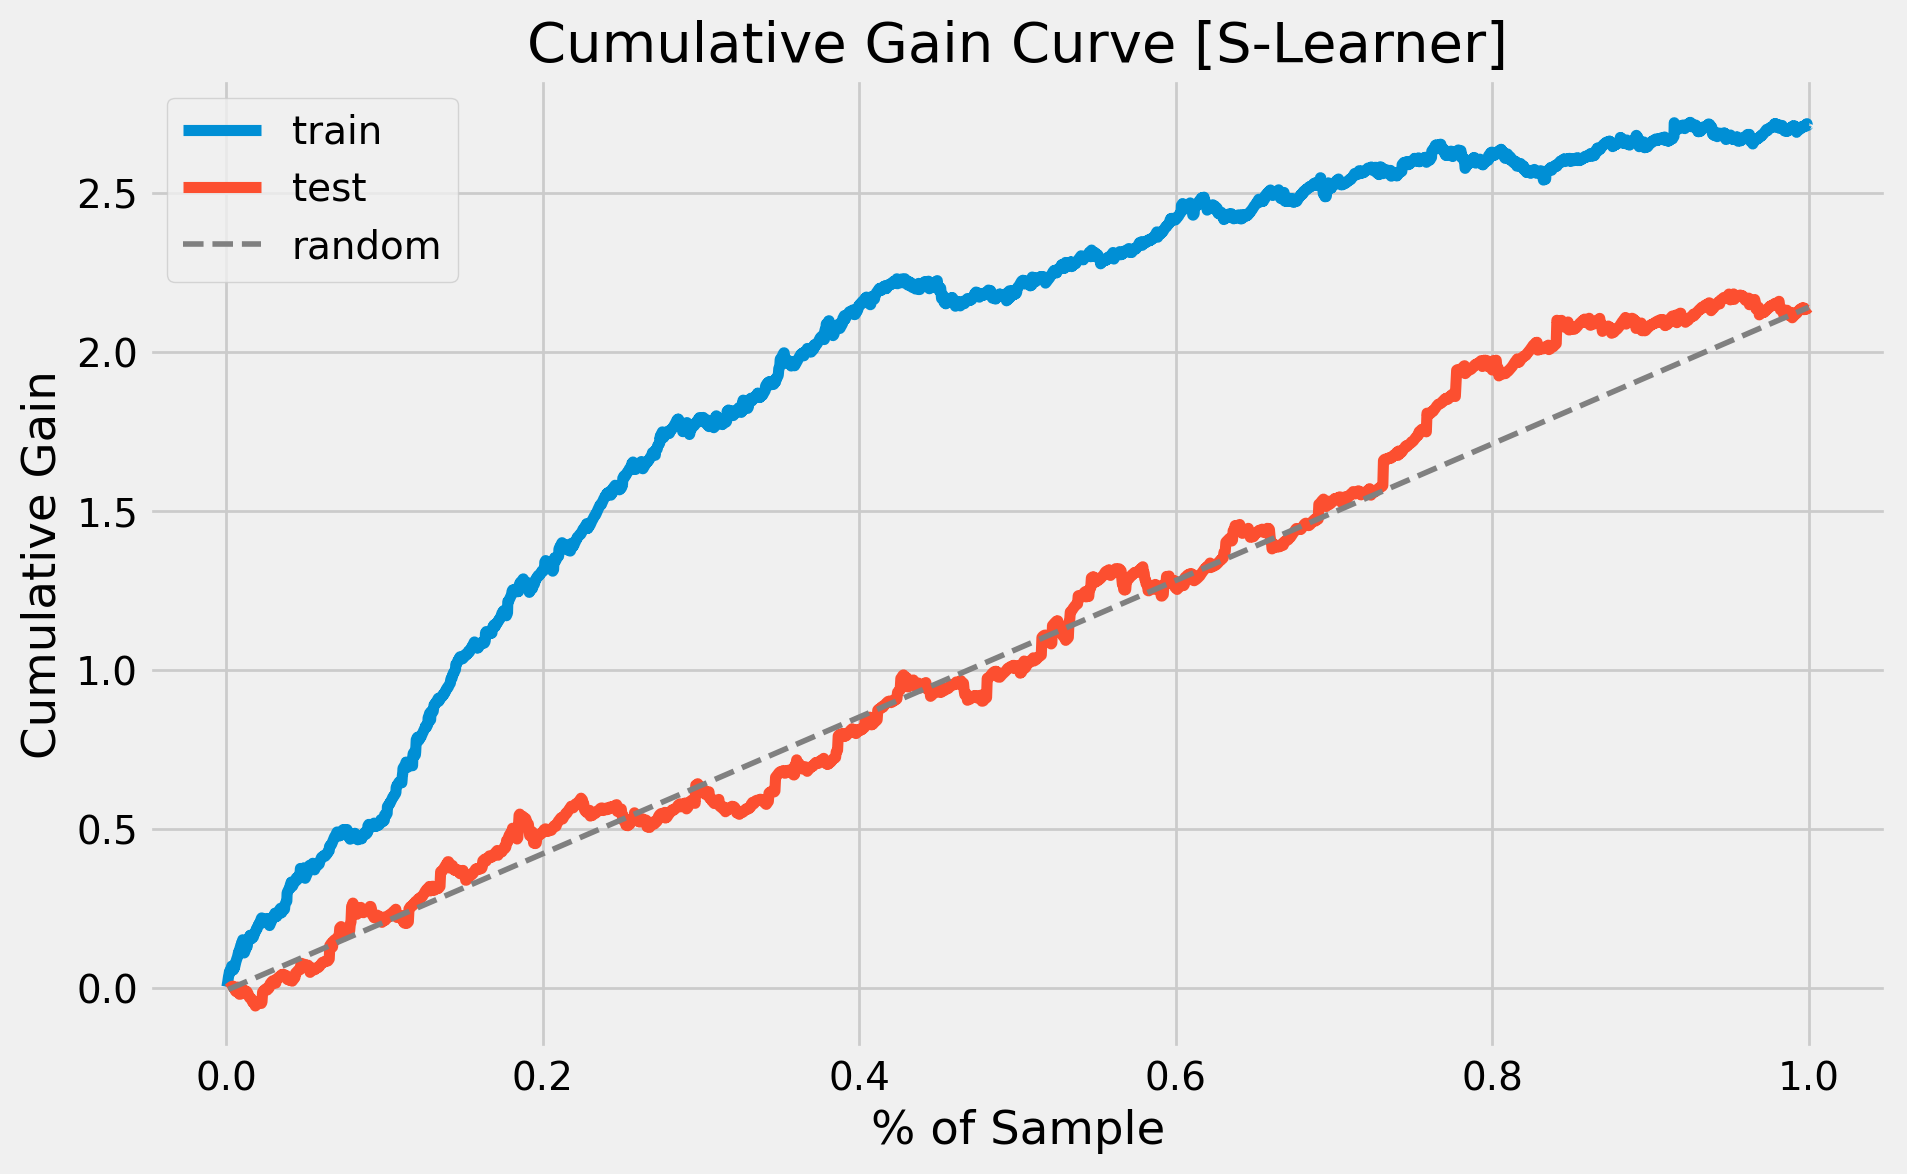

In [17]:
from causal_inference.ml import XLearner

model = XLearner(
    data=df,
    outcome=Y,
    treatment=T,
    covariates_categorical=[col for col in X if col!="age"],
    covariates_numerical="age",
    max_depth=2
)
model.fit()
model.eval()

### 4. R-Learner

In order to explain how the R-Learner works under the hood, we need quite a bit of econometrics.

Let's revisit the concept of orthogonality from instrumental variables - the so-called **Frisch-Waugh-Lovell (FWL)**. Suppose we habe a set of features $X_{1}$ and a different set $X_{2}$, mathematically a linear model could be written as:

$\hat{Y} = \hat{\beta_{1}}X_{1} + \hat{\beta_{2}}X_{2}$

We can estimate $\hat{\beta_{1}}$ by taking advantage of the *orthogonality of residuals*:

1. Regression of $Y$ on $X_{2}$: $\hat{Y}^{*} = \hat{\gamma_{1}}X_{2}$  
2. Regression of $X_{1}$ on $X_{2}$: $\hat{X_{1}}^{*} = \hat{\gamma_{2}}X_{2}$  
3. Computation of residuals: $\tilde{X_{1}} = X_{1} - \hat{X_{1}}^{*}$ and $\tilde{Y} = Y - \hat{Y}^{*}$
4. Regress the residuals of the outcome on the residuals of the features: $\tilde{Y} = \hat{\beta_{1}}\tilde{X_{1}}$

In the context of estimation of causal effects, we can simply do the following:

$Y - \mathbb{E}[Y|X] = \tau (T - \mathbb{E}[T|X]) + \epsilon$

This allows us to capture complex patterns and nonlinearities when estimating the resuduals by applying nonparametric models. **The power we gain from ML is hence flexibility**. However, it is necessary to be cautious, as overfitting might become a problem.

In order to avoid overfitting, we take advantage of **cross prediction and out-of-fold residuals**. For each fold, we estimate the residualization model on K-1 folds, using the model to predict CATE within the fold.

For our CATE model:

$\tilde{Y} = \hat{\beta_{0}} + \hat{\beta_{1}}\tilde{T} + \hat{\beta_{1}}\tilde{T}X + \epsilon$

So far this is awesome! We can really focus our attention on estimating CATE without the burden of estimating the nuisance parameters. Unfortunately, there is an important shortcoming of this approach: we are still using a linear model after the residualization. For some scenarios, this might be OK, but for cases where there is no linear relationship, the estimates will end up being biased.

We can leverage what we've accomplished so far in order to come up with a **nonparametric approach**. Let's assume that $\hat{M_{t}}(X_{i})$ is the model for the treatment on the covariates, and $\hat{M_{y}}(X_{i})$ is the model for the outcome on the covariates. The error term would look like:

$\epsilon = (\hat{Y_{i}} - \hat{M_{y}}(X_{i}) - \tau (T - \hat{M_{t}}(X_{i}))$

If we minimize the square of this term, and transform it a little bit, we can obtain an actual **causal loss function**.

$\hat{L(\tau)} = \frac{1}{N}\sum_{i=1}^{N}(\tilde{Y_{i}} - \tau \tilde{T})^2 = \frac{1}{N}\sum_{i=1}^{N}\tilde{T}^2(\frac{\tilde{Y_{i}}}{\tilde{T}} - \tau )^2$

Minimizing this whole expression is equivalent to predicting $\frac{\tilde{Y_{i}}}{\tilde{T}}$ and weighting it by $\tilde{T}^2$.

Hence, the power of the R-Learner is that **we can use any predictive model at our disposal as the final model**.

In [18]:
from sklearn.model_selection import cross_val_predict

In [19]:
np.random.seed(99)

class RLearnerModel(object):

    def __init__(self, Y, T, X):
        self._Y = Y
        self._T = T
        self._X = X
        self._model_Yres = LGBMRegressor(max_depth=3, random_state=99)
        self._model_Tres = LGBMRegressor(max_depth=3, random_state=99)
        self._model = LGBMRegressor(max_depth=3, random_state=99)

    def fit(self, df: pd.DataFrame):
        np.random.seed(99)
        df_ = df.assign(**{
            f"{self._Y}_res": df[self._Y] - cross_val_predict(self._model_Yres, df[self._X], df[self._T], cv=3),
            f"{self._T}_res": df[self._T] - cross_val_predict(self._model_Tres, df[self._X], df[self._T], cv=3)
        })
        y_tilde = df_[f"{self._Y}_res"] / df_[f"{self._T}_res"]
        self._model.fit(df_[self._X], y_tilde, sample_weight=df_[f"{self._T}_res"]**2)

    def predict(self, df: pd.DataFrame):
        return self._model.predict(df[self._X])

model = RLearnerModel(Y, T, X)
model.fit(df_train)

df_s_train = df_train.assign(
    cate=(
        model.predict(df_train)
    )
)
df_s_test = df_test.assign(
    cate=(
        model.predict(df_test)
    )
)

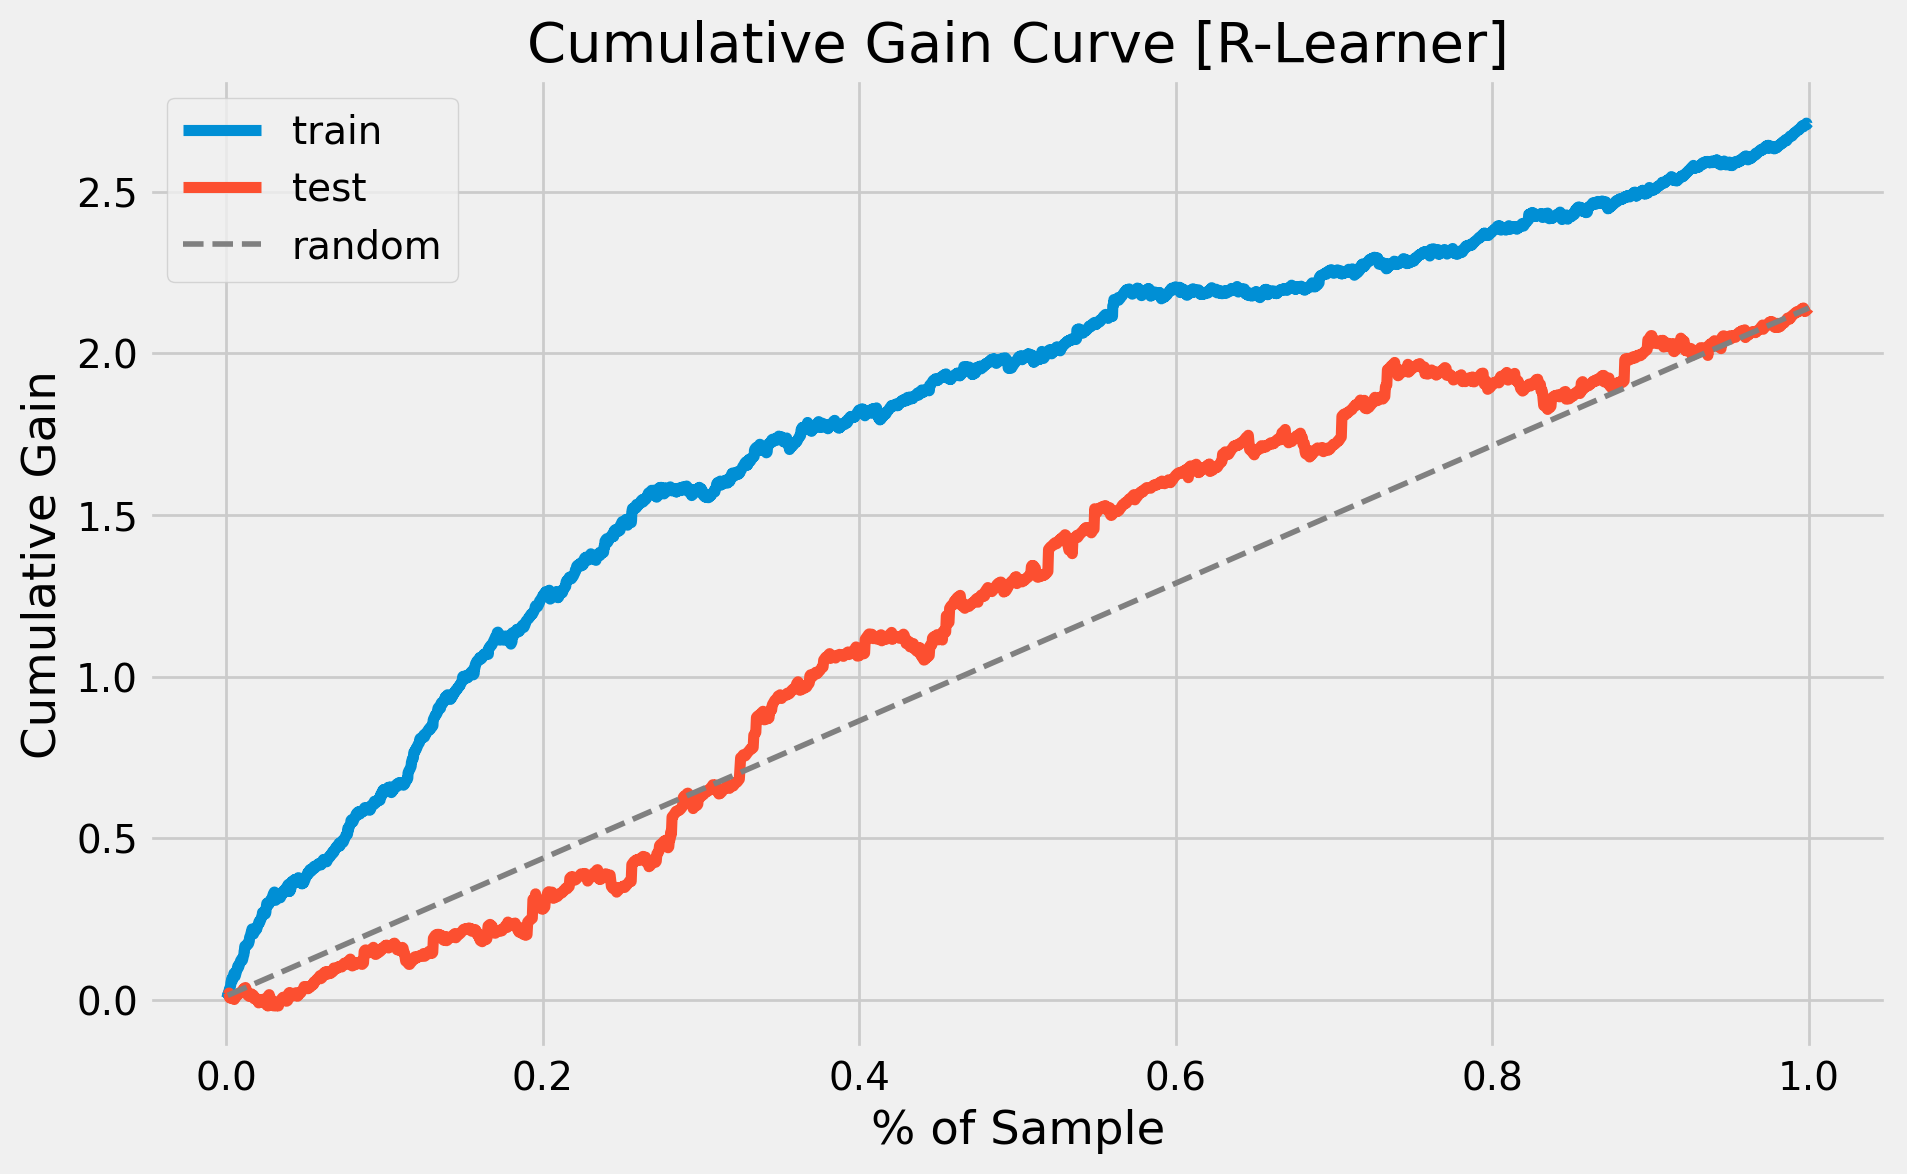

In [20]:
cumulative_gain_eval = CumulativeGainEvaluator(
    train=df_train,
    test=df_test,
    model=model,
    outcome=Y,
    treatment=T,
    covariates=X,
    model_name="R-Learner"
)
cumulative_gain_eval.fit()
cumulative_gain_eval.eval()